## HW02 Conditional AutoEncoder (PyTorch)

MNIST 데이터셋을 이용해 conditional autoencoder (Conditional AE) 기반 generative model을 구축한다.

1. Autoencoder의 fully connected layer를 convolution layer로 수정한다.
2. 조건(condition)은 데이터의 label로 부여한다.

다음을 확인하는 리포트를 Colab 노트북을 이용하여 작성한다.

1. 인코더와 디코더를 별개의 class로 구현해 본다.
2. 조건(condition)을 Conditional AE의 인코더와 디코더에 어떻게 텐서 형태를 취해 입력으로 주어야 하는지 명시하고, 이에 대해 논의한다.
3. 학습을 마친 Conditional AE에 대해, *조건별로* z의 분포를 가시화 한다.
4. z의 차원을 임의로 바꾸어 보고, 이때 결과가 어떻게 달라지는지 확인한다.

***

# 조건부 오토인코더 (PyTorch)
PyTorch를 이용해, 오토인코더(autoencoder)를 구현한다.
* Google Colab 환경에서 사용하는 경우에  초점을 맞춤.
* PyTorch

참고문헌
* [PyTorch Documentation](https://pytorch.org/docs/stable/index.html)
* [Deep Learning with Python, by Francois Chollet](https://github.com/fchollet/deep-learning-with-python-notebooks)
* [Dive into Deep learning](https://d2l.ai/)

주의사항
* Colab에서 코드에 이상이 없음에도 불구하고 결과가 제대로 나오지 않을 경우, '런타임 다시 시작...'을 해보도록 한다.'


## Deep Neural Network 기초
다음 비디오를 보고 심층신경망(deep neural network) 기반 딥러닝 기법은 이해하도록 한다.
* [신경망이란 무엇인가? | 1장.딥러닝에 관하여 (3Blue1Brown)](https://youtu.be/aircAruvnKk)
* [경사 하강, 신경 네트워크가 학습하는 방법 | 심층 학습, 2장 (3Blue1Brown)](https://youtu.be/IHZwWFHWa-w)
* [What is backpropagation really doing? | Deep learning, chapter 3 (3Blue1Brown)](https://youtu.be/Ilg3gGewQ5U)
* [Backpropagation calculus | Deep learning, chapter 4 (3Blue1Brown)](https://youtu.be/tIeHLnjs5U8)


## PyTorch를 사용하기 위한 구성
```
import torch                                      # PyTorch 임포트
import torch.nn as nn                             # nn 모듈 임포트

import torchvision                                # Torchvision 임포트
import torchvision.transforms as transforms       # numpy 이미지에서 tensor 이미지로 변경하기 위한 모듈
import torchvision.datasets as datasets           # PyTorch 내장된 Dataset을 불러오기 위한 모듈

import numpy as np
import matplotlib.pyplot as plt

print(torch.__version__)        # PyTorch 버전을 확인하도록 한다.
print(torchvision.__version__)        # Torchvision 버전을 확인하도록 한다.
```

In [90]:
import time
from tqdm import tqdm

import torch                                      # PyTorch 임포트
import torch.nn as nn                             # nn 모듈 임포트

import torchvision                                # Torchvision 임포트
import torchvision.transforms as transforms       # numpy 이미지에서 tensor 이미지로 변경하기 위한 모듈
import torchvision.datasets as datasets           # PyTorch 내장된 Dataset을 불러오기 위한 모듈

import numpy as np
import matplotlib.pyplot as plt

print(torch.__version__)        # PyTorch 버전을 확인하도록 한다.
print(torchvision.__version__)        # Torchvision 버전을 확인하도록 한다.

1.13.1+cu116
0.14.1+cu116


## GPU 동작 확인

In [91]:
use_cuda = torch.cuda.is_available()
print(use_cuda)

if use_cuda:
  print(torch.cuda.get_device_name(0))

device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

True
Tesla T4
cuda:0


## Hyperparameter 설정

* Batch size
* Learning rate
* Epoch

In [92]:
num_classes = 10

epochs = 20
batch_size = 100
lr = 0.003

## MNIST 데이터셋 띄우기
![MnistExamples.png](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)
* mnist 데이터셋은 숫자(digit) 손글씨 데이터셋이다.
* 60,000개의 트레이닝 데이터와 10,000개의 테스트 데이터로 이루어져 있다.
* LeCun이 자신의 연구에서 활용하고 배포한 데이터셋이 있으나 최근 보편적으로 많이 활용하기 때문에 텐서플로우나 파이토치 등에서 built-in 데이터셋의 형태로 제공해 주기도 한다.  

### MNIST 이미지 데이터
* MNIST 데이터셋은 여러 버젼이 있으나, 여기서는 이를 파이토치에 맞게 정리하여 torchvision.datasets에서 built-in으로 제공하는 데이터셋을 쓰도록 하겠다. ([link](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html)) 
  + (PIL image, integer label)로 구성된 데이터를 제공.
  + PIL image는 각 픽셀이 [0, 255] 사이값으로 구성된 H x W x C 크기의 이미지이다.
* 뉴럴넷의 입력으로 넣기 위해 픽셀값이 0 근처에 있는 작은 실수값을 가지도록 다음과 같이 변환한다.
  + ToTensor(): [0, 255] 사이 값을 [0.0, 1.0] 사이값으로 변화시킴과 동시에 C x H x W 형태로 변환시킨다.

In [93]:
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

# download path 정의
download_root = './MNIST_DATASET'


# PIL image (H x W x C) -> torch tensor (C x H x W) and 
# [0, 255] -> [0.0, 1.0]
mnist_transform = transforms.Compose([
    transforms.ToTensor(), 
])

train_dataset = MNIST(download_root, 
                      transform=mnist_transform, 
                      train=True, 
                      download=True)

test_dataset = MNIST(download_root,
                     transform=mnist_transform, 
                     train=False, 
                     download=False)

## 데이터셋 확인
데이터셋을 로딩한 후 **데이터셋 구성**이 어떻게 되어 있는지 **반드시 확인**하는 습관을 가지도록 한다.

torchvision.datasets.MNIST 데이터셋의 각 데이터는 (이미지, 레이블)로 구성된 튜플이다. 

다음은 MNIST 데이터셋에 있는 이미지와 레이블에 대한 각종 정보를 확인하는 코드이다. 

해당 코드를 통해 다음 사항을 확인할 수 있다.
* train_dataset의 길이는 60,000이다. 
* test_dataset의 길이는 10,000이다.

### MNIST 이미지 데이터
* 각 이미지는 C X H x W 순서로 구성된 [1, 28, 28] 모양의 텐서로 로딩되었다.
* 각 이미지 픽셀값은 ToTensor() 변환을 통해 [0.0, 1.0] 사이의 값으로 변환되었다.
* 각 이미지 픽셀값은 `torch.float32` 타입이다.
* 각 레이블 값의 타입은 파이썬 `int` 형이다.

### MNIST 라벨 데이터
* 각 레이블 값은 [0, 9] 사이의 파이썬 `int`형이다.

## MNIST DataLoader 정의

파이토치 데이터로더는 데이터셋을 배치단위로 묶어 순회(iteration)할 수 있도록 한다. 

아래 코드는 데이터셋에 대한 데이터로더를 만들고, 각 배치가 어떤 텐서 형태로 구성되어 있는지 확인하는 코드이다. 
* 데이터로더에서는 이미지들이 배치단위로 묶였기 때문에, [B, C, H, W] 모양의 텐서가 되었음을 확인하자.
* 데이터로더에서는 레이블들이 배치단위로 묶였기 때문에, [B] 모양의 텐서가 되었음을 확인하자.

train_dataset과 test_dataset은 동일 형태이므로, train_dataset의 데이터로더에 대해서만 확인하였다.


In [94]:
from torch.utils.data import DataLoader

# dataloader 정의
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

In [95]:
def print_MNIST_data_loader_info(data_loader):
  print(">>> dataset length: ", len(data_loader))
  print(">>> batch_size: ", data_loader.batch_size)
  batch_images, batch_labels = next(iter(train_loader))
  # batch size로 묶은 data 이미지의 형태 확인
  print(">>> batch_images type", type(batch_images))
  print(">>> batch_images shape", batch_images.shape)
  print(">>> batch_images dtype", batch_images.dtype)

print("train dataset")
print_MNIST_data_loader_info(train_loader)

print("test dataset")
print_MNIST_data_loader_info(test_loader)

train dataset
>>> dataset length:  600
>>> batch_size:  100
>>> batch_images type <class 'torch.Tensor'>
>>> batch_images shape torch.Size([100, 1, 28, 28])
>>> batch_images dtype torch.float32
test dataset
>>> dataset length:  100
>>> batch_size:  100
>>> batch_images type <class 'torch.Tensor'>
>>> batch_images shape torch.Size([100, 1, 28, 28])
>>> batch_images dtype torch.float32


### 첫번째 배치의 첫번째 이미지와 레이블 확인
첫 이미지와 해당 레이블을 찍어서 확인해 보자.

C x H x W 이미지 정보가 보관된 파이토치 텐서를 H x W x C 형태의 PIL 이미지로 변환시키는 편리한 방법은 `to_pil_images` 함수를 사용하는 것이다. 이 예제에서는 [-1.0, 1.0] 값으로 픽셀값이 normalize되어 있으므로, [0.0, 1.0] 값으로 denormalize 시킨 후, 호출하면 [0, 255] 값으로 


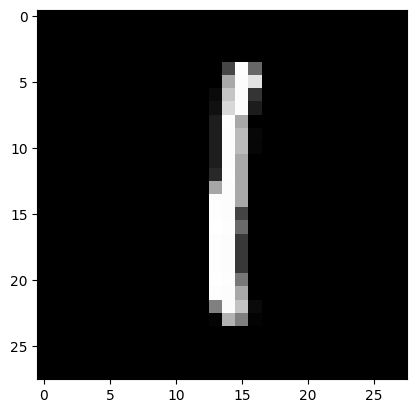

In [96]:
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

# 첫번째 이미지 한장에 대한 확인
batch_images, batch_labels = next(iter(train_loader))

img = batch_images[0]

plt.figure()
plt.imshow(to_pil_image(img), cmap='gray')

## 네트워크 모델 설계
* 인코더 모델: nn.Module을 상속받는 Class 내의 함수로 작성
  + InputLayer로 (1,28,28) 영상을 받고, 출력으로 n_dim차원 벡터가 나오도록 함.
* 디코더 모델: nn.Module을 상속받는 Class 내의 함수로 작성
  + InputLayer에서 n_dim차원 벡터를 받고, 출력으로 (1,28,28) 영상이 나오도록 함.
* 오토인코더 모델: nn.Module을 상속받는 Class로 작성
  + 주의: InputLayer를 추가해야 곧장 함수로서 활용할 수 있음.


여기서는 n_dim을 수업시간과는 달리 2로 설정한다.
* 즉, n_dim=2

In [97]:
n_dim = 2

## TODO (1)

아래 코드와 달리 인코더와 디코더를 별개의 class로 나누어 구현해 본다.

## TODO (2)

모든 layer는 convolution layer로 수정한다. 

조건(condition)이 어떤 형태로 주어져야 하는지를 명시하고, 이에 대해 논의한다.

-> 제가 작성한 코드에서는 label을 one-hot vector 형태로 입력 받습니다. 이를 통해 label의 정보를 모델에 전달할 수 있고, label의 범주형 정보를 연속형 벡터로 변환하여 연산이 가능하게 했습니다.
또한, 입력 이미지와 라벨을 결합한 벡터를 처리하는데 전부 convolution layer만이 아닌 linear layer를 함께 사용한 이유는 벡터를 펼친 후 fully connected layer를 통해 처리하는 것이 더 효과적이라 생각하였기 때문입니다. 따라서 저는 convolution layer와 linear layer를 섞어 사용하여 입력 정보를 처리하였습니다.

## Encoder
- (1, 28, 28) 크기의 이미지를 입력으로 받도록 입력 레이어 정의
- Flatten으로 입력 tensor를 784-vector로 vectorize
- Fully connected layer로 784 + 10 > 256 > 128 > 32 > n_dim 순으로 차원을 축소

## Decoder
- n_dim 크기의 tensor를 입력으로 받도록 입력 레이어 정의
- Fully connected layer로 n_dim + 10 > 32 > 256 > 784 순으로 차원을 확대
- 784-vector를 Reshape하여 처음 입력 이미지와 같은 (1, 28, 28) tensor로 변환

In [98]:
## TODO
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder
        self.input = nn.Flatten()     # 28 x 28 = 784
        self.fc1 = nn.Linear(794, 256)    # 784 + 10 = 794
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, n_dim)
        
    def encoder(self, x, c):
        x = self.input(x)         # vectorize
        x = torch.cat([x, c], 1)  # condition인 label one-hot vector와 concat
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)

        return x
    
    def forward(self, x, c):
        x = self.encoder(x, c)

        return x

In [99]:
## TODO
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc5 = nn.Linear(n_dim + 10, 32)
        self.fc6 = nn.Linear(32, 128)
        self.fc7 = nn.Linear(128, 256)
        self.fc8 = nn.Linear(256, 784)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def decoder(self, x, c):
        x = torch.cat([x, c], 1)   # encoder에서 만들어진 n_dim 차원 feature vector와 condition을 concat
        x = self.relu(self.fc5(x))
        x = self.relu(self.fc6(x))
        x = self.relu(self.fc7(x))
        x = self.sigmoid(self.fc8(x))

        return x     # 입력으로 받은 image의 shape으로 바꾸어 리턴

    def forward(self, x, c):
        x = self.decoder(z, c)

        return x

In [100]:
## TODO
class CondAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x, c):
        z = self.encoder(x, c)
        x = self.decoder(z, c)

        return x.reshape(-1, 1, 28, 28), z

In [101]:
# 네트워크 모델 생성

ae = CondAE().to(device)

In [102]:
class ConditionalAE(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)  # 14 x 14 x 16
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1) # 7 x 7 x 32
        self.fc1 = nn.Linear(7*7*32 + num_classes, 256)   # 7 x 7 x 32 + 10
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, n_dim)

        # decoder
        self.fc5 = nn.Linear(n_dim + num_classes, 32)
        self.fc6 = nn.Linear(32, 128)
        self.fc7 = nn.Linear(128, 7*7*32)
        self.conv3 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1) # 14 x 14 x 16
        self.conv4 = nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1)  # 28 x 28 x 1

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encoder(self, x, c):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = x.view(-1, 7*7*32)
        x = torch.cat([x, c], 1)  # condition인 label one-hot vector와 concat
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)

        return x

    def decoder(self, x, c):
        x = torch.cat([x, c], 1)
        x = self.relu(self.fc5(x))
        x = self.relu(self.fc6(x))
        x = self.relu(self.fc7(x))
        x = x.view(-1, 32, 7, 7)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.sigmoid(x)

        return x

    def forward(self, x, c):
        z = self.encoder(x, c)
        x = self.decoder(z, c)

        return x, z


In [103]:
# 네트워크 모델 생성

ae = ConditionalAE().to(device)

## 훈련 전, 네트워크 모델을 함수로서 활용
* AutoEncoder ae를 모델로 구성했기 때문에, 지금부터 함수로서 활용 가능 [(효과적인 TensorFlow: 세션 대신 함수)](https://www.tensorflow.org/guide/effective_tf2?hl=ko#%EC%84%B8%EC%85%98_%EB%8C%80%EC%8B%A0_%ED%95%A8%EC%88%98)
  + 단, ae 함수는 batch 단위로 수행됨을 명심할 것.  
    - 단순히, (1, 28, 28) -> ae -> (1, 28, 28)로 동작하지 않고,
    - batch 단위로 (?, 1, 28, 28) -> ae -> (?, 1, 28, 28)로 병렬처리됨.
* 지금은 훈련 전 네트웍이기 때문에 정상적으로 작동하지 않음.

In [104]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import ipywidgets as widgets

def train_dataset_imshow(idx):
  (image, label) = train_dataset[idx]
  print('GT label:', label)

  X                 = torch.unsqueeze(image, 0).to(device)                              # batch size = 1 
  
  label             = torch.tensor([label])
  label             = label.view(label.shape[0], 1)
  one_hot_labels    = torch.zeros(label.shape[0], num_classes).scatter_(1, label, 1)
  C                 = one_hot_labels.to(device)                                         # batch size = 1
  Y_pred            = ae(X, C)[0]

  input_img  = to_pil_image(X.squeeze())
  output_img = to_pil_image(Y_pred.squeeze())
  
  plt.subplot(121)
  plt.imshow(input_img, cmap='gray')
  
  plt.subplot(122)
  plt.imshow(output_img, cmap='gray')

  plt.show()

widgets.interact(train_dataset_imshow, idx=widgets.IntSlider(min=0, max=len(train_dataset)-1, continuous_update=False))

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

<function __main__.train_dataset_imshow(idx)>

## 네트워크 모델 구조 확인
- torchinfo 라이브러리를 사용

In [105]:
pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [106]:
from torchinfo import summary

summary(ae, [(batch_size, 1, 28, 28), (batch_size, 10)])

Layer (type:depth-idx)                   Output Shape              Param #
ConditionalAE                            [100, 1, 28, 28]          --
├─Conv2d: 1-1                            [100, 16, 14, 14]         160
├─ReLU: 1-2                              [100, 16, 14, 14]         --
├─Conv2d: 1-3                            [100, 32, 7, 7]           4,640
├─ReLU: 1-4                              [100, 32, 7, 7]           --
├─Linear: 1-5                            [100, 256]                404,224
├─ReLU: 1-6                              [100, 256]                --
├─Linear: 1-7                            [100, 128]                32,896
├─ReLU: 1-8                              [100, 128]                --
├─Linear: 1-9                            [100, 32]                 4,128
├─ReLU: 1-10                             [100, 32]                 --
├─Linear: 1-11                           [100, 2]                  66
├─Linear: 1-12                           [100, 32]                 41

## Optimizer, loss 함수 설정
학습과정에서 사용할 optimizer, loss 함수를 설정한다.
* [optim module](https://pytorch.org/docs/stable/optim.html) 참고<br/>
optimizier 이론적 학습: [www](https://brunch.co.kr/@chris-song/50)<br/>
optimizer: torch.optim 모듈 내의  함수들을 다음의 예약어로 쓸 수 있다.
  + sgd = SGD
  + rmsprop = RMSprop
  + adagrad = Adagrad
  + adadelta = Adadelta
  + adam = Adam
  + adamax = Adamax
* [nn module](https://pytorch.org/docs/stable/nn.html) 참고 <br/> 
loss:  torch.nn 모듈 내의  함수들을 다음의 예약어로 쓸 수 있다.
  + mse = MSELoss = mean_squared_error
  + mae = L1Loss = mean_absolute_error
  + kld = KLDivLoss = kullback_leibler_divergence
  + crossentropy = CrossEntropyLoss

In [107]:
# optimizer 설정
optimizer = torch.optim.Adam(ae.parameters(), lr=lr)

# loss function 설정
criterion = nn.MSELoss()

In [108]:
# Training

if use_cuda:
  ae = ae.cuda()

for epoch in tqdm(range(epochs)):
  start = time.time()
  avg_loss = 0
  total_batch = len(train_loader)

  for i, (images, labels) in enumerate(train_loader):
    # labels -> one-hot vector
    labels = labels.view(batch_size, 1)
    labels = torch.zeros(labels.size(0), num_classes).scatter_(1, labels, 1)


    if use_cuda:
      images = images.to(device)
      labels = labels.to(device)

    # forward propagation
    pred = ae(images, labels)[0]

    # loss 측정
    loss = criterion(pred, images)

    # backward propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    avg_loss += loss / total_batch

  print("[Epoch: {:>4}] \t loss = {:.4f} \t time = {:.4f}"
        .format(epoch + 1, avg_loss.data, time.time() - start))

print("Learning Finished!")

  5%|▌         | 1/20 [00:11<03:32, 11.18s/it]

[Epoch:    1] 	 loss = 0.0596 	 time = 11.1839


 10%|█         | 2/20 [00:26<04:00, 13.36s/it]

[Epoch:    2] 	 loss = 0.0351 	 time = 14.8769


 15%|█▌        | 3/20 [00:42<04:09, 14.65s/it]

[Epoch:    3] 	 loss = 0.0338 	 time = 16.1875


 20%|██        | 4/20 [00:53<03:31, 13.20s/it]

[Epoch:    4] 	 loss = 0.0333 	 time = 10.9616


 25%|██▌       | 5/20 [01:04<03:06, 12.44s/it]

[Epoch:    5] 	 loss = 0.0329 	 time = 11.1020


 30%|███       | 6/20 [01:15<02:46, 11.89s/it]

[Epoch:    6] 	 loss = 0.0326 	 time = 10.8258


 35%|███▌      | 7/20 [01:26<02:30, 11.59s/it]

[Epoch:    7] 	 loss = 0.0324 	 time = 10.9512


 40%|████      | 8/20 [01:38<02:20, 11.72s/it]

[Epoch:    8] 	 loss = 0.0322 	 time = 11.9989


 45%|████▌     | 9/20 [01:48<02:05, 11.38s/it]

[Epoch:    9] 	 loss = 0.0320 	 time = 10.6496


 50%|█████     | 10/20 [01:59<01:52, 11.25s/it]

[Epoch:   10] 	 loss = 0.0319 	 time = 10.9291


 55%|█████▌    | 11/20 [02:10<01:40, 11.21s/it]

[Epoch:   11] 	 loss = 0.0318 	 time = 11.1135


 60%|██████    | 12/20 [02:21<01:29, 11.14s/it]

[Epoch:   12] 	 loss = 0.0317 	 time = 10.9968


 65%|██████▌   | 13/20 [02:32<01:17, 11.10s/it]

[Epoch:   13] 	 loss = 0.0317 	 time = 10.9979


 70%|███████   | 14/20 [02:43<01:06, 11.08s/it]

[Epoch:   14] 	 loss = 0.0315 	 time = 11.0327


 75%|███████▌  | 15/20 [02:54<00:55, 11.06s/it]

[Epoch:   15] 	 loss = 0.0314 	 time = 11.0063


 80%|████████  | 16/20 [03:05<00:44, 11.02s/it]

[Epoch:   16] 	 loss = 0.0314 	 time = 10.9370


 85%|████████▌ | 17/20 [03:16<00:33, 11.04s/it]

[Epoch:   17] 	 loss = 0.0313 	 time = 11.0852


 90%|█████████ | 18/20 [03:27<00:22, 11.03s/it]

[Epoch:   18] 	 loss = 0.0312 	 time = 10.9892


 95%|█████████▌| 19/20 [03:38<00:10, 10.88s/it]

[Epoch:   19] 	 loss = 0.0311 	 time = 10.5431


100%|██████████| 20/20 [03:49<00:00, 11.45s/it]

[Epoch:   20] 	 loss = 0.0312 	 time = 10.6801
Learning Finished!


## 트레이닝이 끝난 오토인코더를 이용하기
트레이닝이 끝난 오토인코더는 함수로서 작동이 가능하다. 

In [109]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import ipywidgets as widgets

def train_dataset_imshow(idx):
  (image, label) = train_dataset[idx]
  print('GT label:', label)

  X                 = torch.unsqueeze(image, 0).to(device)                              # batch size = 1 

  label             = torch.tensor([label])
  label             = label.view(label.shape[0], 1)
  one_hot_labels    = torch.zeros(label.shape[0], num_classes).scatter_(1, label, 1)
  C                 = one_hot_labels.to(device)
  Y_pred            = ae(X, C)[0]                                                          # batch size = 1

  input_img  = to_pil_image(X.squeeze())
  output_img = to_pil_image(Y_pred.squeeze())
  
  plt.subplot(121)
  plt.imshow(input_img, cmap='gray')
  
  plt.subplot(122)
  plt.imshow(output_img, cmap='gray')

  plt.show()

widgets.interact(train_dataset_imshow, idx=widgets.IntSlider(min=0, max=len(train_dataset)-1, continuous_update=False))

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

<function __main__.train_dataset_imshow(idx)>

# 디코더를 이용한 Generative Model 구성
## 디코더 부분을 따로 사용하기

`ConditionalAE` Class의 decoder 함수를 이용하여 트레이닝이 끝난 조건부 오토인코더의 디코더 부분만 따로 사용할 수 있다.

```
# 입력으로 주는 데이터는 
# decode 단의 처음 input shape에 맞추어야 한다.

ae.decoder()
```

## 디코딩 테스트 입력 결과 확인
* 인코딩 결과와 유사한 좌표값을 디코딩에 보내도 유사한 결과가 나옴을 확인한다.

In [110]:
## 디코더의 테스트 입력 설정

import ipywidgets as widgets

u=widgets.FloatSlider(min=-5.0, max=5.0)
v=widgets.FloatSlider(min=-5.0, max=5.0)

ui = widgets.HBox([u,v])

def z_test(u, v):
  z_test = np.array([[u,v]])
  c_test = np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]])
  print(z_test)

  z_test = torch.tensor(z_test.astype(np.float32))
  c_test = torch.tensor(c_test.astype(np.float32))


  img_gen = ae.decoder(z_test.to(device), c_test.to(device)).reshape(-1, 28, 28)
  plt.imshow(img_gen[0].cpu().detach().numpy(), cmap='gray')
  plt.show()  

out = widgets.interactive_output(z_test, {'u': u, 'v': v})

display(ui, out)

Output()

## TODO (3)

Autoencoder의 인코더가 만들어 내는 representation인 z 값을 조건별로 가시화 한다. 

tensor([[-0.5794,  2.1847],
        [-0.9199,  7.5261],
        [-2.8676, 10.6324],
        ...,
        [-0.9665,  2.7728],
        [-4.0948,  3.1031],
        [-0.3234,  0.4646]], device='cuda:0', grad_fn=<AddmmBackward0>)
torch.Size([980, 2])
torch.Size([1135, 2])
torch.Size([1032, 2])
torch.Size([1010, 2])
torch.Size([982, 2])
torch.Size([892, 2])
torch.Size([958, 2])
torch.Size([1028, 2])
torch.Size([974, 2])
torch.Size([1009, 2])


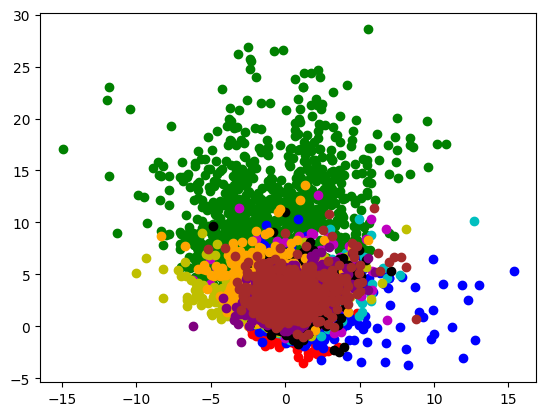

In [111]:
# MNIST 데이터의 latent code 가시화
import matplotlib.pyplot as plt

# 테스트셋의 whole batch에 대한 결과 확인을 위한 dataloader 정의
whole_test_loader = DataLoader(dataset=test_dataset,
                               batch_size=len(test_dataset),
                               shuffle=False)
whole_test_images, whole_test_labels = next(iter(whole_test_loader))

whole_test_labels_  = whole_test_labels.view(whole_test_labels.shape[0], 1)
one_hot_labels      = torch.zeros(whole_test_labels_.shape[0], num_classes).scatter_(1, whole_test_labels_, 1).to(device)

whole_test_images = whole_test_images.to(device)
whole_test_labels = whole_test_labels.to(device)

# TODO: whole_test_images에 대한 인코딩 함수 enc()를 이용해 latent codes z 구하기 
z = ae.encoder(whole_test_images, one_hot_labels)
print(z)

# z 배열을 레이블 조건을 이용해 슬라이싱
z_0 = z[whole_test_labels==0]
z_1 = z[whole_test_labels==1]
z_2 = z[whole_test_labels==2]
z_3 = z[whole_test_labels==3]
z_4 = z[whole_test_labels==4]
z_5 = z[whole_test_labels==5]
z_6 = z[whole_test_labels==6]
z_7 = z[whole_test_labels==7]
z_8 = z[whole_test_labels==8]
z_9 = z[whole_test_labels==9]

print(z_0.shape)
print(z_1.shape)
print(z_2.shape)
print(z_3.shape)
print(z_4.shape)
print(z_5.shape)
print(z_6.shape)
print(z_7.shape)
print(z_8.shape)
print(z_9.shape)

colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']
# TODO: 레이블 별로 다른 색을 이용해 가시화
plt.plot(z_0[:,0].detach().cpu().numpy(), z_0[:,1].detach().cpu().numpy(), marker='o', linestyle='', color=colors[0])
plt.plot(z_1[:,0].detach().cpu().numpy(), z_1[:,1].detach().cpu().numpy(), marker='o', linestyle='', color=colors[1])
plt.plot(z_2[:,0].detach().cpu().numpy(), z_2[:,1].detach().cpu().numpy(), marker='o', linestyle='', color=colors[2])
plt.plot(z_3[:,0].detach().cpu().numpy(), z_3[:,1].detach().cpu().numpy(), marker='o', linestyle='', color=colors[3])
plt.plot(z_4[:,0].detach().cpu().numpy(), z_4[:,1].detach().cpu().numpy(), marker='o', linestyle='', color=colors[4])
plt.plot(z_5[:,0].detach().cpu().numpy(), z_5[:,1].detach().cpu().numpy(), marker='o', linestyle='', color=colors[5])
plt.plot(z_6[:,0].detach().cpu().numpy(), z_6[:,1].detach().cpu().numpy(), marker='o', linestyle='', color=colors[6])
plt.plot(z_7[:,0].detach().cpu().numpy(), z_7[:,1].detach().cpu().numpy(), marker='o', linestyle='', color=colors[7])
plt.plot(z_8[:,0].detach().cpu().numpy(), z_8[:,1].detach().cpu().numpy(), marker='o', linestyle='', color=colors[8])
plt.plot(z_9[:,0].detach().cpu().numpy(), z_9[:,1].detach().cpu().numpy(), marker='o', linestyle='', color=colors[9])

## TODO (4)

z의 차원을 임의로 바꾸어 보고, 이때 결과가 어떻게 달라지는지 확인한다.

In [112]:
#n_dim = 5
n_dim= 10
# n_dim을 5, 10으로 설정 후 각각 결과를 확인

class ConditionalAE(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)  # 14 x 14 x 16
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1) # 7 x 7 x 32
        self.fc1 = nn.Linear(7*7*32 + num_classes, 256)   # 7 x 7 x 32 + 10
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, n_dim)

        # decoder
        self.fc5 = nn.Linear(n_dim + num_classes, 32)
        self.fc6 = nn.Linear(32, 128)
        self.fc7 = nn.Linear(128, 7*7*32)
        self.conv3 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1) # 14 x 14 x 16
        self.conv4 = nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1)  # 28 x 28 x 1

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encoder(self, x, c):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = x.view(-1, 7*7*32)
        x = torch.cat([x, c], 1)  # condition인 label one-hot vector와 concat
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)

        return x

    def decoder(self, x, c):
        x = torch.cat([x, c], 1)
        x = self.relu(self.fc5(x))
        x = self.relu(self.fc6(x))
        x = self.relu(self.fc7(x))
        x = x.view(-1, 32, 7, 7)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.sigmoid(x)

        return x

    def forward(self, x, c):
        z = self.encoder(x, c)
        x = self.decoder(z, c)

        return x, z

In [113]:
# 네트워크 모델 생성

ae = ConditionalAE().to(device)

In [114]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import ipywidgets as widgets

def train_dataset_imshow(idx):
  (image, label) = train_dataset[idx]
  print('GT label:', label)

  X                 = torch.unsqueeze(image, 0).to(device)                              # batch size = 1 
  
  label             = torch.tensor([label])
  label             = label.view(label.shape[0], 1)
  one_hot_labels    = torch.zeros(label.shape[0], num_classes).scatter_(1, label, 1)
  C                 = one_hot_labels.to(device)                                         # batch size = 1
  Y_pred            = ae(X, C)[0]

  input_img  = to_pil_image(X.squeeze())
  output_img = to_pil_image(Y_pred.squeeze())
  
  plt.subplot(121)
  plt.imshow(input_img, cmap='gray')
  
  plt.subplot(122)
  plt.imshow(output_img, cmap='gray')

  plt.show()

widgets.interact(train_dataset_imshow, idx=widgets.IntSlider(min=0, max=len(train_dataset)-1, continuous_update=False))

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

<function __main__.train_dataset_imshow(idx)>

In [115]:
# optimizer 설정
optimizer = torch.optim.Adam(ae.parameters(), lr=lr)

# loss function 설정
criterion = nn.MSELoss()

In [116]:
# Training

if use_cuda:
  ae = ae.cuda()

for epoch in tqdm(range(epochs)):
  start = time.time()
  avg_loss = 0
  total_batch = len(train_loader)

  for i, (images, labels) in enumerate(train_loader):
    # labels -> one-hot vector
    labels = labels.view(batch_size, 1)
    labels = torch.zeros(labels.size(0), num_classes).scatter_(1, labels, 1)


    if use_cuda:
      images = images.to(device)
      labels = labels.to(device)

    # forward propagation
    pred = ae(images, labels)[0]

    # loss 측정
    loss = criterion(pred, images)

    # backward propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    avg_loss += loss / total_batch

  print("[Epoch: {:>4}] \t loss = {:.4f} \t time = {:.4f}"
        .format(epoch + 1, avg_loss.data, time.time() - start))

print("Learning Finished!")

  5%|▌         | 1/20 [00:10<03:22, 10.65s/it]

[Epoch:    1] 	 loss = 0.0416 	 time = 10.6531


 10%|█         | 2/20 [00:27<04:21, 14.51s/it]

[Epoch:    2] 	 loss = 0.0213 	 time = 17.2031


 15%|█▌        | 3/20 [00:41<03:58, 14.00s/it]

[Epoch:    3] 	 loss = 0.0178 	 time = 13.3916


 20%|██        | 4/20 [00:52<03:24, 12.79s/it]

[Epoch:    4] 	 loss = 0.0160 	 time = 10.9400


 25%|██▌       | 5/20 [01:03<03:01, 12.13s/it]

[Epoch:    5] 	 loss = 0.0149 	 time = 10.9495


 30%|███       | 6/20 [01:14<02:44, 11.72s/it]

[Epoch:    6] 	 loss = 0.0142 	 time = 10.9191


 35%|███▌      | 7/20 [01:24<02:27, 11.38s/it]

[Epoch:    7] 	 loss = 0.0138 	 time = 10.6678


 40%|████      | 8/20 [01:35<02:14, 11.18s/it]

[Epoch:    8] 	 loss = 0.0133 	 time = 10.7443


 45%|████▌     | 9/20 [01:47<02:06, 11.51s/it]

[Epoch:    9] 	 loss = 0.0129 	 time = 12.2463


 50%|█████     | 10/20 [01:58<01:53, 11.30s/it]

[Epoch:   10] 	 loss = 0.0126 	 time = 10.8394


 55%|█████▌    | 11/20 [02:09<01:41, 11.23s/it]

[Epoch:   11] 	 loss = 0.0122 	 time = 11.0616


 60%|██████    | 12/20 [02:20<01:28, 11.12s/it]

[Epoch:   12] 	 loss = 0.0119 	 time = 10.8606


 65%|██████▌   | 13/20 [02:31<01:17, 11.07s/it]

[Epoch:   13] 	 loss = 0.0116 	 time = 10.9672


 70%|███████   | 14/20 [02:42<01:06, 11.09s/it]

[Epoch:   14] 	 loss = 0.0114 	 time = 11.1195


 75%|███████▌  | 15/20 [02:53<00:55, 11.03s/it]

[Epoch:   15] 	 loss = 0.0113 	 time = 10.8895


 80%|████████  | 16/20 [03:04<00:44, 11.00s/it]

[Epoch:   16] 	 loss = 0.0112 	 time = 10.9442


 85%|████████▌ | 17/20 [03:15<00:33, 11.02s/it]

[Epoch:   17] 	 loss = 0.0110 	 time = 11.0554


 90%|█████████ | 18/20 [03:25<00:21, 10.84s/it]

[Epoch:   18] 	 loss = 0.0109 	 time = 10.4324


 95%|█████████▌| 19/20 [03:36<00:10, 10.82s/it]

[Epoch:   19] 	 loss = 0.0108 	 time = 10.7450


100%|██████████| 20/20 [03:47<00:00, 11.38s/it]

[Epoch:   20] 	 loss = 0.0107 	 time = 10.9850
Learning Finished!


tensor([[-2.6710e-01, -1.1281e+00, -1.0395e+00,  ..., -2.2289e+00,
          4.8438e-01, -3.8469e-01],
        [-2.6863e+00, -3.2490e+00,  8.5092e-01,  ...,  1.2167e+00,
          2.1560e+00, -8.4637e-01],
        [-6.8415e-01, -1.7371e+00,  1.2032e+00,  ..., -5.4760e-02,
         -9.4145e-02, -4.1001e-01],
        ...,
        [-8.1974e-01, -3.0869e+00, -2.6078e-03,  ..., -1.3741e+00,
         -9.4592e-02, -3.2658e-01],
        [-9.0418e-01, -1.6941e+00,  8.1808e-01,  ..., -1.7754e+00,
          5.4555e-01, -1.1003e+00],
        [-1.9351e+00, -2.7496e+00, -7.2337e-01,  ...,  2.1378e-01,
          5.5211e-01, -4.3078e-02]], device='cuda:0', grad_fn=<AddmmBackward0>)
torch.Size([980, 10])
torch.Size([1135, 10])
torch.Size([1032, 10])
torch.Size([1010, 10])
torch.Size([982, 10])
torch.Size([892, 10])
torch.Size([958, 10])
torch.Size([1028, 10])
torch.Size([974, 10])
torch.Size([1009, 10])


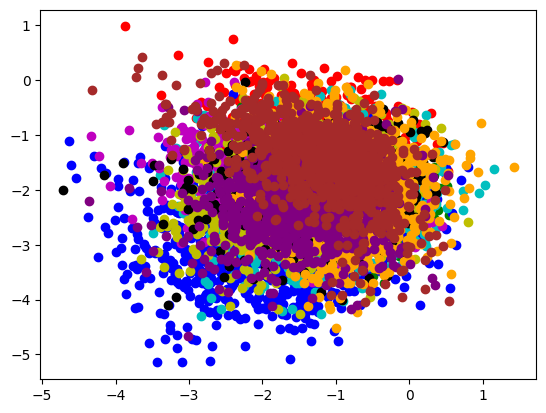

In [117]:
# MNIST 데이터의 latent code 가시화
import matplotlib.pyplot as plt

# 테스트셋의 whole batch에 대한 결과 확인을 위한 dataloader 정의
whole_test_loader = DataLoader(dataset=test_dataset,
                               batch_size=len(test_dataset),
                               shuffle=False)
whole_test_images, whole_test_labels = next(iter(whole_test_loader))

whole_test_labels_  = whole_test_labels.view(whole_test_labels.shape[0], 1)
one_hot_labels      = torch.zeros(whole_test_labels_.shape[0], num_classes).scatter_(1, whole_test_labels_, 1).to(device)

whole_test_images = whole_test_images.to(device)
whole_test_labels = whole_test_labels.to(device)

# TODO: whole_test_images에 대한 인코딩 함수 enc()를 이용해 latent codes z 구하기 
z = ae.encoder(whole_test_images, one_hot_labels)
print(z)

# z 배열을 레이블 조건을 이용해 슬라이싱
z_0 = z[whole_test_labels==0]
z_1 = z[whole_test_labels==1]
z_2 = z[whole_test_labels==2]
z_3 = z[whole_test_labels==3]
z_4 = z[whole_test_labels==4]
z_5 = z[whole_test_labels==5]
z_6 = z[whole_test_labels==6]
z_7 = z[whole_test_labels==7]
z_8 = z[whole_test_labels==8]
z_9 = z[whole_test_labels==9]

print(z_0.shape)
print(z_1.shape)
print(z_2.shape)
print(z_3.shape)
print(z_4.shape)
print(z_5.shape)
print(z_6.shape)
print(z_7.shape)
print(z_8.shape)
print(z_9.shape)

colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']
# TODO: 레이블 별로 다른 색을 이용해 가시화
plt.plot(z_0[:,0].detach().cpu().numpy(), z_0[:,1].detach().cpu().numpy(), marker='o', linestyle='', color=colors[0])
plt.plot(z_1[:,0].detach().cpu().numpy(), z_1[:,1].detach().cpu().numpy(), marker='o', linestyle='', color=colors[1])
plt.plot(z_2[:,0].detach().cpu().numpy(), z_2[:,1].detach().cpu().numpy(), marker='o', linestyle='', color=colors[2])
plt.plot(z_3[:,0].detach().cpu().numpy(), z_3[:,1].detach().cpu().numpy(), marker='o', linestyle='', color=colors[3])
plt.plot(z_4[:,0].detach().cpu().numpy(), z_4[:,1].detach().cpu().numpy(), marker='o', linestyle='', color=colors[4])
plt.plot(z_5[:,0].detach().cpu().numpy(), z_5[:,1].detach().cpu().numpy(), marker='o', linestyle='', color=colors[5])
plt.plot(z_6[:,0].detach().cpu().numpy(), z_6[:,1].detach().cpu().numpy(), marker='o', linestyle='', color=colors[6])
plt.plot(z_7[:,0].detach().cpu().numpy(), z_7[:,1].detach().cpu().numpy(), marker='o', linestyle='', color=colors[7])
plt.plot(z_8[:,0].detach().cpu().numpy(), z_8[:,1].detach().cpu().numpy(), marker='o', linestyle='', color=colors[8])
plt.plot(z_9[:,0].detach().cpu().numpy(), z_9[:,1].detach().cpu().numpy(), marker='o', linestyle='', color=colors[9])

다음 사진은 각각 n_dim = 5로 설정하였을때의 loss, z 가시화 결과의 캡쳐 사진입니다.
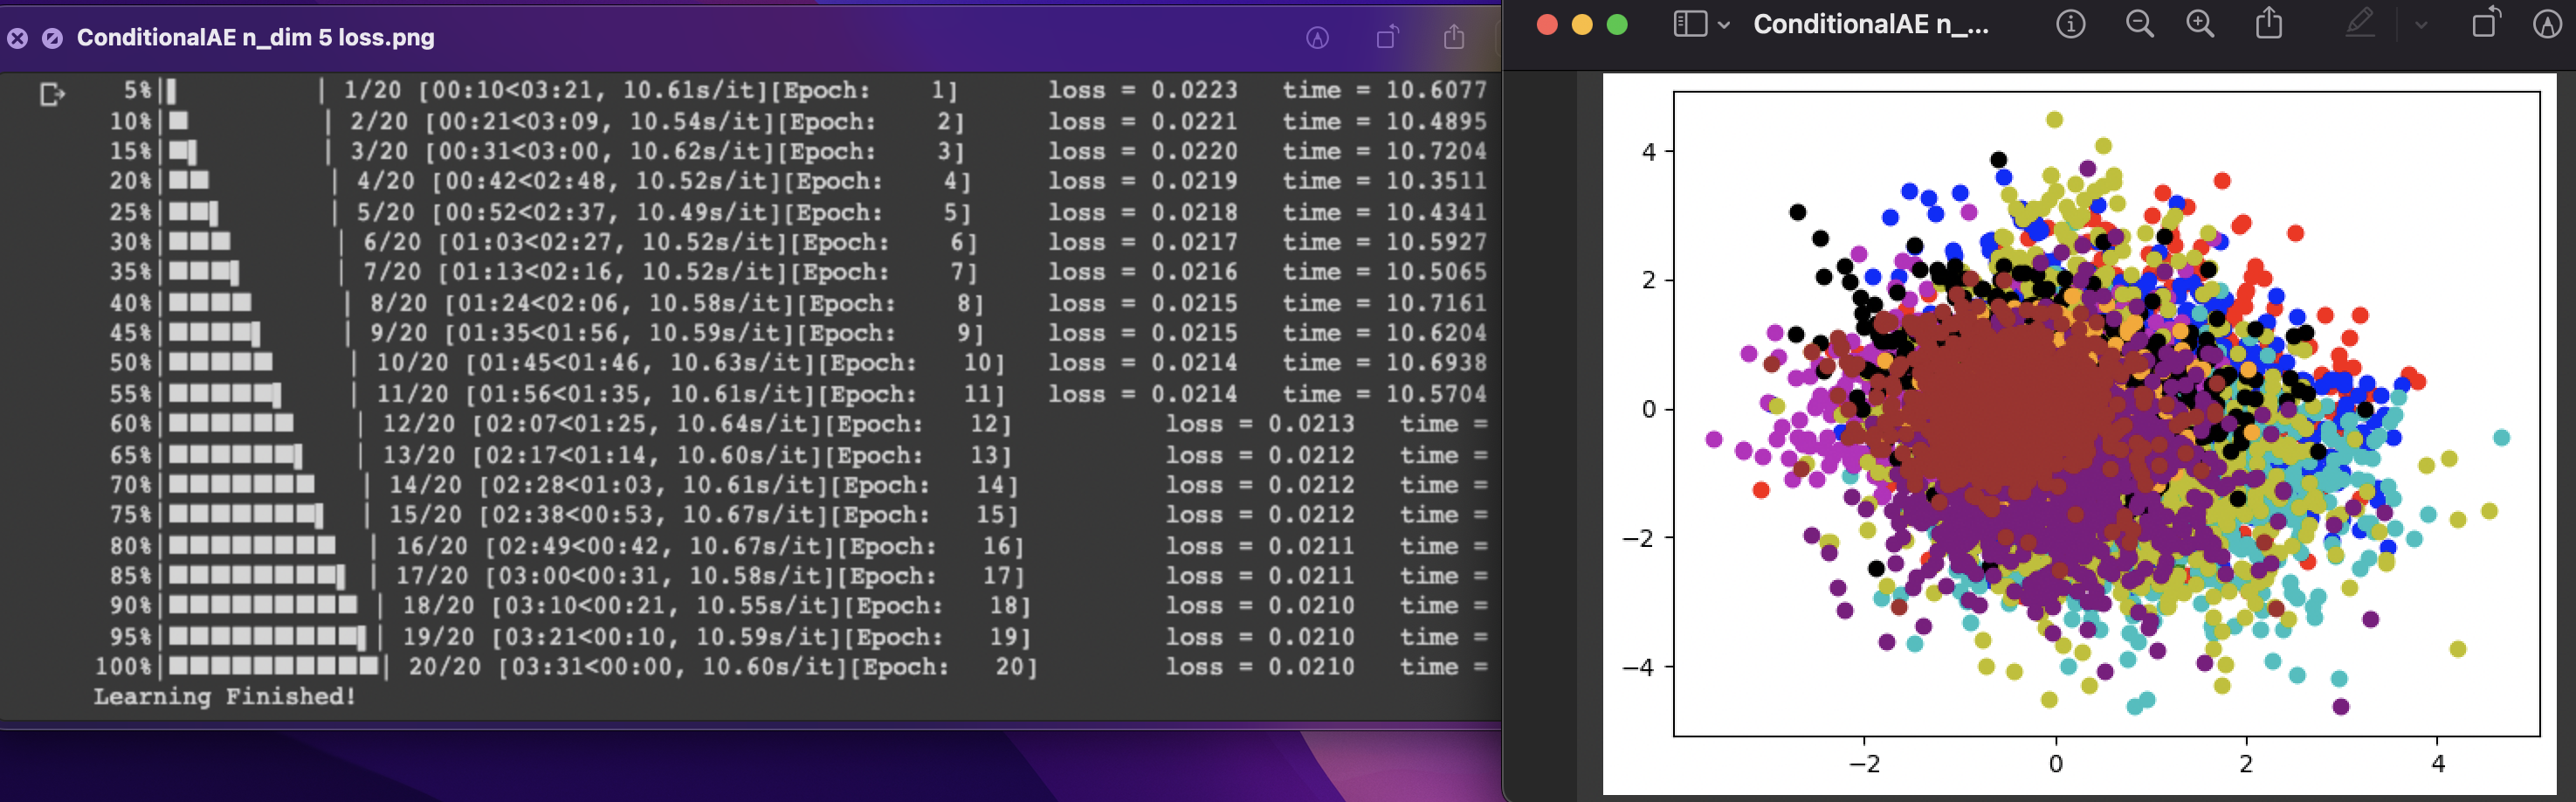